# Pythonではじめる機械学習

## はじめての（簡単な）機械学習アプリケーション

増加するwebリクエストに対応したいと考えている。余分なサーバ費用をできるだけ発生させずに、サーバを増築しなければならない時期を事前に予測したい。

### データを読み込む

**ch01/data/web_traffic.tsv**というファイルでwebリクエストに関するデータが保存されている。

In [95]:
import scipy as sp
data = sp.genfromtxt("web_traffic.tsv", delimiter="\t")

読み込んだファイルを出力してみると、行ごとに時間の**インデックス**とその時間における**アクセス数**が入力されている。

In [96]:
print(data[:10])

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]


In [97]:
print(data.shape)

(743, 2)


ここでは、2次元のデータポイントが743個あることが分かる。

### 前処理とデータ整形

scypiで処理を行い場合、データを次元ごとに分割して扱う。ここでxは経過時間、yはアクセス数を表している。

In [98]:
x = data[:,0]
y = data[:,1]

ここ、yには不適切な値である**nan**が含まれていることに注意する。ここではどれだけnanが含まれているか調べてみる。

In [99]:
print(sp.sum(sp.isnan(y)))

8


**sp.isnan(y)**は配列の要素が数値であるかどうかboolean方の配列を返す。ここでは8つのデータが欠損していることが分かる。

以下のようにして、yで適切な値を持つ要素に対して、x, yの要素を取り出す。

In [100]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

このデータについて散布図を用いて可視化を行った。

In [101]:
import matplotlib.pyplot as plt

colors=['g','k','b','m','r']
# linestyles={'-', '', '--', ':', '-'}

def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    """
    hoge
    """
    plt.figure(num=None, figsize=(8,6))
    plt.clf()
    plt.scatter(x, y, s=10, c='w')
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])
    
    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            plt.plot(mx, model(mx), linewidth=4, c=color)
        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)

    if ymax:
        plt.ylim(ymax=ymax)

    if xmin:
        plt.xlim(xmin=xmin)
    
    plt.grid(True, linestyle='-', color='0.75')

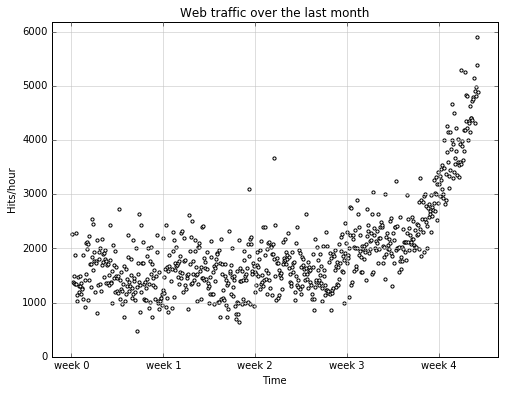

In [102]:
%matplotlib inline

plot_models(x, y, None)

### 正しいモデルの選択と機械学習

「今のサーバで、いつまでトラフィックに耐えることができるか？」という問題について考える。
* ノイズの含まれたデータに対して、その背後にある本当のモデルを見つける
* そのモデルを用いて、インフラがパンクする時期を予測する

#### はじめてのモデル構築

「モデル」とは、複雑な現実世界で起こる現象を理論的に単純化して近似したものである。  
近似した場合、常に誤差(error)が生じることになるが、この誤差を手がかりにして、正しいモデルを選択する。

学習したモデル関数$f$が存在すると仮定して、経過時間$x$、アクセス数$y$であると、誤差$E$は
$$
    E = \sum_{}{}(f(x)-y)^2
$$
で表すことができる。

In [103]:
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

#### 単純な直線で近似する

ここでは、扱う対称が直線で表現できる単純なモデルであると仮定する。

考えるべき問題は、グラフ上でどのように直線を配置したら誤差を最小にできるかということである。ここではpolyfit()を利用して1次近似を行う。

In [104]:
fp1, residuals, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)

**polyfit()**は近似したモデル関数についての**パラメータ**である**fp1**を返す。full=Trueとすると、近似プロセスについて詳細を得ることができる。ここではresiduals, rank, sv, rcondが該当するが、近似誤差を表す**residuals**を詳しく見る。

In [105]:
print("Model parameters: %s" % fp1)
print("residuals: %s" % residuals)

Model parameters: [   2.59619213  989.02487106]
residuals: [  3.17389767e+08]


これは次の関数が最適な近似関数であることを示している。
$$
    f(x) = 2.59619213x + 989.02487106
$$

**poly1d()**を用いることで、モデルパラメータからモデル関数を作ることができる。

In [106]:
f1 = sp.poly1d(fp1)
print(error(f1, x, y))

317389767.34


f1()を用いて訓練データから学習したモデルを図に描画してみる。

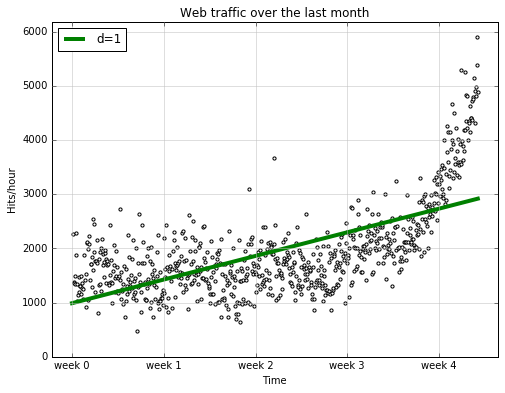

In [107]:
%matplotlib inline

plot_models(x, y, [f1])

#### より進んだやり方へ

より複雑なモデルである「次数が2の多項式曲線」に当てはめて、データを見ていく。

In [108]:
f2p = sp.polyfit(x, y, 2)
print(f2p)

[  1.05322215e-02  -5.26545650e+00   1.97476082e+03]


In [109]:
f2 = sp.poly1d(f2p)
print(error(f2, x, y))

179983507.878


新しいモデルの誤差は179,983,507.878であり、直線で近似したモデルのときの**約半分の誤差**になっている。しかしながらより複雑な関数が必要になっている。

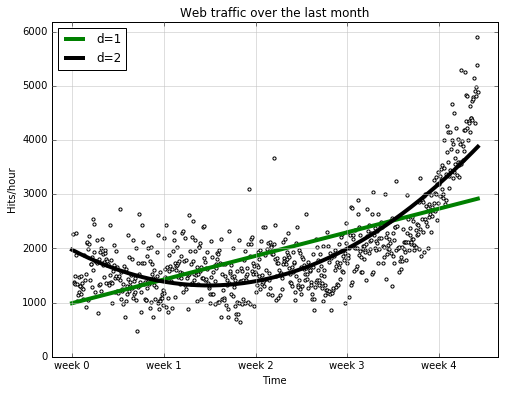

In [110]:
%matplotlib inline

plot_models(x, y, [f1, f2])

In [111]:
print(f2)

         2
0.01053 x - 5.265 x + 1975


poly1d()で2次近似を求めた結果、
$$
    f(x) = 0.01053x^2 - 5.265x + 1975
$$
のような式になることが分かる。

/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/numpy/lib/polynomial.py:587: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


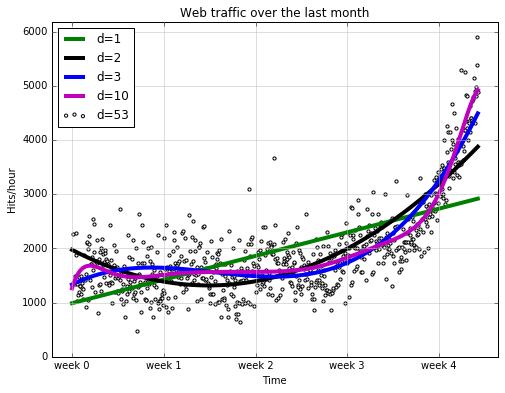

In [112]:
f3p = sp.polyfit(x,y,3)
f3 = sp.poly1d(f3p)

f10p = sp.polyfit(x,y,10)
f10 = sp.poly1d(f10p)

f100p = sp.polyfit(x,y,100)
f100 = sp.poly1d(f100p)

plot_models(x, y, [f1, f2, f3, f10, f100])

より次元を高くし、複雑にした結果どうなるだろうか。モデルを複雑にすればするほど、誤差も減っているように見える。

In [113]:
print("Error d=1   : %f" % error(f1, x, y))
print("Error d=2   : %f" % error(f2, x, y))
print("Error d=3   : %f" % error(f3, x, y))
print("Error d=10  : %f" % error(f10, x, y))
print("Error d=100 : %f" % error(f100, x, y))

Error d=1   : 317389767.339778
Error d=2   : 179983507.878179
Error d=3   : 139350144.031725
Error d=10  : 121942326.363536
Error d=100 : 109452398.303054


モデルを複雑にするとデータに適応していくが、複雑にするに連れて適応**しすぎる**ように見える。これはデータに含まれているノイズまで捉えてしまっているからである。こういった現象は**過学習(overfitting)**と呼ばれている。

この時点で以下のことに注意すべきである。
* 多項式モデルからどれか一つを選択する
* より複雑なモデル（スプライン曲線など）に切り替える
* データについて別の視点で考え、はじめからやり直す

#### データを違う視点から眺める

データについて別の視点から考えてみることにする。3週と4週の間で急に変化していることが分かる。3.5週を堺にしてデータを分割して、2つの直線で近似してみることにする。

In [115]:
inflection = 3.5 * 7 * 24 # 変化点(急に変化する点)の時間を計算
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)

print("Error inflection = %f" % (fa_error + fb_error)

Error inflection = 132950348.197616


/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an i

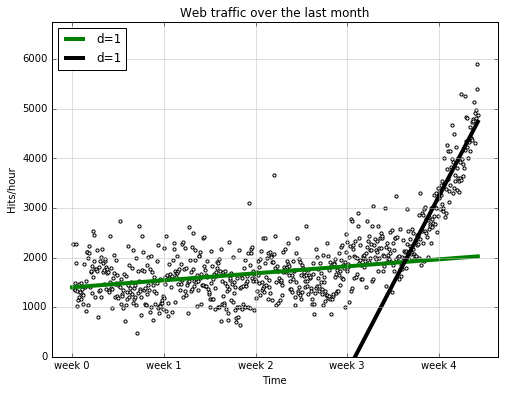

In [117]:
plot_models(x, y, [fa, fb])

2つの直線を用いて近似を行ったほうが、今までのモデルよりも優れているように見える。しかしながら誤差は大きいままである。これは信頼できる値なのだろうか。

言い換えると、「なぜ最後の週のデータを直線で近似するのが良いと考えたのか。なぜそれが他の複雑なモデルより優れていると考えたのか」ということになる。ここでは、未来についてのグラフを描画することで、正しいモデルについて分かるかもしれない。

/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/numpy/lib/polynomial.py:587: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/cyberangel/.pyenv/versions/miniconda3-latest/envs/ipython-notebook-env/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


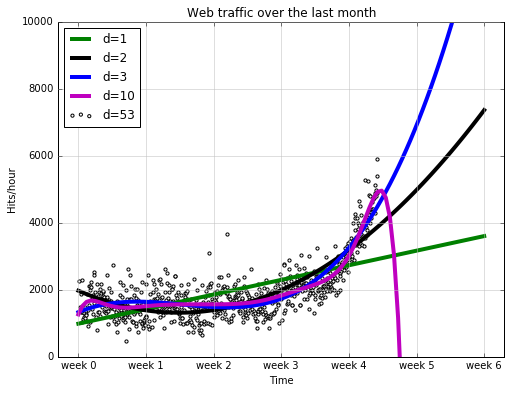

In [120]:
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))

plot_models(x, y, [f1, f2, f3, f10, f100], mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100), ymax=10000, xmin=0 * 7 * 24)